# Fiber picking

Identify possible chromosome fibers from decoded genomic loci from previous steps

# 1. Import packages

In [1]:
import sys
import os
sys.path.append(r"C:\Users\cosmosyw\Documents\Softwares")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd
import numpy as np

import tqdm
import pickle
import time

import matplotlib.pyplot as plt
import seaborn as sns

17964


# 2. Load refgen df

In [2]:
# the reference dataframe is used for picking
# the old version is for replicates B1 and B2 and the new version is for replicates B3 and B4.
df_refgen=pd.read_csv(r"E:\DNA_analysis\refgen_df_for_jie_old_CTP.csv")

# 3. Prepare uid to cellID info, genotype info

In [3]:
##################################### Manual input ##############################################
analysis_folder = r'E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508'

rna_exp_names = ['20220809']
replicate_exp = '20220819'
rna_exp_name = '20220809'
##################################### Manual input ##############################################

## Get cell uid info

In [5]:
#from ImageAnalysis3 import segmentation_tools.cell
#from 
ExpFovCell_2_uid = {}

#from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
segLabel_folders = [
    os.path.join(analysis_folder, 'Segmentation'),
]

for _exp, _seg_fd in zip(rna_exp_names, segLabel_folders):
    _seg_fls = [os.path.join(_seg_fd, _fl) for _fl in os.listdir(_seg_fd) if '_Segmentation.hdf5' in _fl]
    for _fl in _seg_fls:
        # load segmentation label matrix and uids
        with h5py.File(_fl, 'r') as _f:
            for _fov_id in _f.keys():
                _fov_group = _f[list(_f.keys())[0]]
                _uid_group = _fov_group['cell_2_uid']
                for _cell_id in _uid_group.keys():
                    ExpFovCell_2_uid[(_exp, _fov_id, _cell_id)] = _uid_group[_cell_id][:][0].decode()

len(ExpFovCell_2_uid)

28013

## Get genotype info

In [6]:
df_genotype = pd.read_csv(r"C:\Users\cosmosyw\Documents\Research\Mecp2_v2\results\cell_composition\df_cell_with_MeCP2_genotype.csv")
uid_to_genotype = {uid:genotype for (uid, genotype) in zip(df_genotype['uid'].values, df_genotype['genotype'].values)}

# 4. Prepare candidate spots

In [7]:
# F drive on Crick, cut from NAS2
decode_exp_folder = os.path.join(analysis_folder,'Exported_hdf5')

## Inspect one fov

In [8]:
fov_id = 10
#cell_id = 0
file_name_format = 'Decoded_Fov-' + str(fov_id) + '.hdf5'
file_name = os.path.join(decode_exp_folder, file_name_format)
print(file_name)
os.path.exists(file_name)

E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-10.hdf5


True

In [9]:
import h5py
with h5py.File(file_name, "r") as f:
    # Print all root level object names (aka keys) 
    # these can be group or dataset names 
    print("Keys: %s" % f.keys())
    cell_key_list = list(f.keys())

Keys: <KeysViewHDF5 ['Cell-10', 'Cell-101', 'Cell-102', 'Cell-103', 'Cell-105', 'Cell-108', 'Cell-109', 'Cell-11', 'Cell-111', 'Cell-115', 'Cell-116', 'Cell-117', 'Cell-118', 'Cell-119', 'Cell-12', 'Cell-121', 'Cell-122', 'Cell-125', 'Cell-14', 'Cell-15', 'Cell-16', 'Cell-17', 'Cell-19', 'Cell-2', 'Cell-20', 'Cell-21', 'Cell-23', 'Cell-24', 'Cell-27', 'Cell-28', 'Cell-29', 'Cell-3', 'Cell-30', 'Cell-32', 'Cell-33', 'Cell-34', 'Cell-36', 'Cell-37', 'Cell-38', 'Cell-39', 'Cell-4', 'Cell-40', 'Cell-41', 'Cell-42', 'Cell-43', 'Cell-46', 'Cell-47', 'Cell-48', 'Cell-49', 'Cell-5', 'Cell-50', 'Cell-52', 'Cell-53', 'Cell-54', 'Cell-56', 'Cell-57', 'Cell-59', 'Cell-6', 'Cell-60', 'Cell-62', 'Cell-63', 'Cell-64', 'Cell-65', 'Cell-66', 'Cell-67', 'Cell-68', 'Cell-7', 'Cell-70', 'Cell-77', 'Cell-8', 'Cell-80', 'Cell-81', 'Cell-83', 'Cell-84', 'Cell-85', 'Cell-87', 'Cell-88', 'Cell-90', 'Cell-98']>


In [10]:
coords_df = pd.read_hdf(file_name, 'Cell-23')
coords_df

,region_name,chr,start,end,center_z,center_x,center_y,center_intensity,center_internal_dist,codebook_name,data_type,num_spots,index,chr_order,subclass
0,12:16251010-16259958,12,16251010,16259958,1405.436158,154214.6688,128968.6788,11355.242333,38.559347,CTP11,combo,3,634,11,L6b
1,8:18753065-18759951,8,18753065,18759951,3110.491333,154799.9748,130348.5336,10741.818333,215.247350,CTP11,combo,3,438,11,L6b
2,16:16249831-16259990,16,16249831,16259990,2380.123917,158124.9528,129362.8788,7347.113000,82.162827,CTP11,combo,3,804,7,L6b
3,X:73752056-73759971,X,73752056,73759971,2515.830750,154030.6260,131262.1092,9344.063000,152.528389,CTP11,combo,3,952,22,L6b
4,4:48751349-48759978,4,48751349,48759978,3729.853292,156646.0476,133411.5144,7675.442667,25.241084,CTP11,combo,3,226,39,L6b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6768,12:83553580-83562760,12,83553580,83562760,5294.472625,157077.2844,129030.7860,429.550385,214.030818,CTP13,combo,2,1690,51,L6b
6769,5:129759307-129774335,5,129759307,129774335,1780.057012,154162.1538,132149.1888,623.438270,295.565843,CTP13,combo,2,1327,95,L6b
6770,16:77417968-77429420,16,77417968,77429420,7662.147125,158388.1074,132371.3070,606.699500,295.741048,CTP13,combo,2,1863,57,L6b
6771,10:98940738-98950337,10,98940738,98950337,2677.174875,158837.2902,132854.4234,636.432275,298.980286,CTP13,combo,2,1597,89,L6b


## Process all fov

### shared params

In [11]:
pixel_z, pixel_x, pixel_y = 250, 108, 108

In [12]:
from tqdm import tqdm

In [13]:
# map info from df_ref_gen to coords; hyb should be the same as chromosome order
geneID_to_hyb = {name:hyb for name, hyb in zip(df_refgen['name'], df_refgen['hyb'])}    

def map_to_hyb(gene_name):
    return geneID_to_hyb[gene_name]

In [14]:
#geneID_to_hyb

In [15]:
decoded_file_list = [os.path.join(decode_exp_folder, _fl) for _fl in os.listdir(decode_exp_folder) if '.hdf5' in _fl]
decoded_file_list[:3]

['E:\\DNA_analysis\\20220819_Mecp2_DNA_from_0809\\Analysis_0508\\Exported_hdf5\\Decoded_Fov-1.hdf5',
 'E:\\DNA_analysis\\20220819_Mecp2_DNA_from_0809\\Analysis_0508\\Exported_hdf5\\Decoded_Fov-10.hdf5',
 'E:\\DNA_analysis\\20220819_Mecp2_DNA_from_0809\\Analysis_0508\\Exported_hdf5\\Decoded_Fov-100.hdf5']

### start process

In [16]:
df_list = []
# ini file counter
file_counts = np.full((len(decoded_file_list),), False)
original_length_list = []
final_length_list = []
cell_ids_list = []

In [17]:
for i, _file in tqdm(enumerate(decoded_file_list[:])):
    #check whether the file has been analyzed
    if file_counts[i]:
        continue
    file_counts[i] = True
    
    with h5py.File(_file, "r") as f:
        #print("Keys: %s" % f.keys())
        # get all cell keys to access the h5df
        cell_key_list = list(f.keys())
    
    # append coords of each cell from the same decoded fov
    _coords_df_fov_list=[]
    for _cell_key in cell_key_list:
        _coords_df = pd.read_hdf(_file, _cell_key)
        # exclude blank spots
        _coords_df = _coords_df[_coords_df['chr']!='B']
        if not _coords_df.empty:
            _coords_df['orig_cellID']=_cell_key
            _coords_df['FOV']=_file.split('Fov-')[-1].split('.hdf5')[0]
            _coords_df['replicate']=replicate_exp
            _coords_df['chr'] = _coords_df['chr'].apply(lambda x: 'chr'+str(x))
            
            # cell id to uid, then to genotype
            _cell_uid = ExpFovCell_2_uid[(rna_exp_name, _file.split('Fov-')[-1].split('.hdf5')[0], _cell_key.split('Cell-')[1])]
            _genotype = uid_to_genotype[_cell_uid]
            _coords_df['finalcellID'] = _cell_uid
            _coords_df['MeCP2_genotype'] = _genotype
            # append
            _coords_df_fov_list.append(_coords_df)
    
    _coords_df_fov = pd.concat(_coords_df_fov_list)

    _coords_df_fov.reset_index(inplace=True)
    _coords_df_fov.rename(columns={'center_z':'z_hat', 'center_y':'y_hat', 'center_x':'x_hat', 
                                    }, inplace = True)
    
    # spot num each fov
    original_length = len(_coords_df_fov)
    original_length_list.append(original_length)
        
    # convert physical locations to pixle...
    # since 1 z pixel is not equvilant to 1 x/y pixel, convert z pixel to pseudo pixel
    #_coords_df_fov.loc[:,'z_hat'] = (np.array(_coords_df_fov.loc[:,'z_hat'].values)/pixel_z)
    _coords_df_fov.loc[:,'z_hat'] = (np.array(_coords_df_fov.loc[:,'z_hat'].values)/pixel_z)*pixel_z/pixel_x
    _coords_df_fov.loc[:,'y_hat'] = np.array(_coords_df_fov.loc[:,'y_hat'].values)/pixel_y
    _coords_df_fov.loc[:,'x_hat'] = np.array(_coords_df_fov.loc[:,'x_hat'].values)/pixel_x

    #sigma = np.full((len(_coords_df_fov,),), 1)
    sigma = 1
    _coords_df_fov['sig_x'] = sigma
    _coords_df_fov['sig_y'] = sigma
    _coords_df_fov['sig_z'] = sigma

    # append info below if necessary (some are redundant..)
    # record hyb
    _coords_df_fov['hyb'] = _coords_df_fov['region_name'].apply(lambda x: map_to_hyb(x))
    # get other attributes for the dataframe
    _coords_df_fov['celltype'] = _coords_df_fov['subclass']
    # drop redundant info
    _coords_df_fov.drop(columns=['level_0','subclass'],inplace=True)

    
    # append each fov
    df_list.append(_coords_df_fov)
    final_length = len(_coords_df_fov)
    final_length_list.append(final_length)

    print(f'finishing processing {_file}')
    print(f'{final_length} is kept out of {original_length}')

1it [00:01,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-1.hdf5
266847 is kept out of 266847


2it [00:03,  1.57s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-10.hdf5
390791 is kept out of 390791


3it [00:04,  1.53s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-100.hdf5
279034 is kept out of 279034


4it [00:05,  1.50s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-101.hdf5
275178 is kept out of 275178


5it [00:06,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-102.hdf5
133641 is kept out of 133641


6it [00:07,  1.21s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-103.hdf5
183197 is kept out of 183197


7it [00:09,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-104.hdf5
285758 is kept out of 285758


8it [00:10,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-105.hdf5
273204 is kept out of 273204


9it [00:12,  1.32s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-106.hdf5
300347 is kept out of 300347


10it [00:13,  1.30s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-107.hdf5
256989 is kept out of 256989


11it [00:14,  1.30s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-108.hdf5
283413 is kept out of 283413


12it [00:15,  1.22s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-109.hdf5
206842 is kept out of 206842


13it [00:17,  1.34s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-11.hdf5
374399 is kept out of 374399


14it [00:17,  1.17s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-110.hdf5
169625 is kept out of 169625


15it [00:18,  1.10it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-111.hdf5
59160 is kept out of 59160


16it [00:18,  1.26it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-112.hdf5
89891 is kept out of 89891


17it [00:19,  1.54it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-113.hdf5
65366 is kept out of 65366


18it [00:19,  1.67it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-114.hdf5
72435 is kept out of 72435


19it [00:20,  1.88it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-115.hdf5
67321 is kept out of 67321


20it [00:20,  1.89it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-116.hdf5
99954 is kept out of 99954


21it [00:20,  2.03it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-117.hdf5
70726 is kept out of 70726


22it [00:21,  1.54it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-118.hdf5
202891 is kept out of 202891


23it [00:23,  1.23it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-119.hdf5
247649 is kept out of 247649


24it [00:25,  1.17s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-12.hdf5
372399 is kept out of 372399


25it [00:26,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-120.hdf5
283997 is kept out of 283997


26it [00:28,  1.39s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-121.hdf5
294040 is kept out of 294040


27it [00:30,  1.50s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-122.hdf5
330710 is kept out of 330710


28it [00:31,  1.61s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-123.hdf5
431066 is kept out of 431066


29it [00:33,  1.68s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-124.hdf5
369087 is kept out of 369087


30it [00:35,  1.67s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-125.hdf5
365694 is kept out of 365694


31it [00:37,  1.78s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-126.hdf5
380677 is kept out of 380677


32it [00:38,  1.49s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-127.hdf5
147560 is kept out of 147560


33it [00:39,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-128.hdf5
144539 is kept out of 144539


34it [00:40,  1.24s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-129.hdf5
235097 is kept out of 235097


35it [00:41,  1.33s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-13.hdf5
326791 is kept out of 326791


36it [00:43,  1.36s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-130.hdf5
290202 is kept out of 290202


37it [00:44,  1.38s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-131.hdf5
278348 is kept out of 278348


38it [00:46,  1.44s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-132.hdf5
302252 is kept out of 302252


39it [00:47,  1.29s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-133.hdf5
221579 is kept out of 221579


40it [00:47,  1.07s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-134.hdf5
122170 is kept out of 122170


41it [00:48,  1.09s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-135.hdf5
290366 is kept out of 290366


42it [00:50,  1.12s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-136.hdf5
242214 is kept out of 242214


43it [00:51,  1.12s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-137.hdf5
236712 is kept out of 236712


44it [00:52,  1.10s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-138.hdf5
219241 is kept out of 219241


45it [00:53,  1.16s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-139.hdf5
273257 is kept out of 273257


46it [00:54,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-14.hdf5
276507 is kept out of 276507


47it [00:56,  1.22s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-140.hdf5
221801 is kept out of 221801


48it [00:57,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-141.hdf5
271320 is kept out of 271320


49it [00:58,  1.29s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-142.hdf5
253161 is kept out of 253161


50it [01:00,  1.34s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-143.hdf5
285368 is kept out of 285368


51it [01:01,  1.32s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-144.hdf5
262403 is kept out of 262403


52it [01:02,  1.28s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-145.hdf5
234014 is kept out of 234014


53it [01:03,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-146.hdf5
243085 is kept out of 243085


54it [01:05,  1.22s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-147.hdf5
223170 is kept out of 223170


55it [01:06,  1.14s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-148.hdf5
196644 is kept out of 196644


56it [01:07,  1.14s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-149.hdf5
244093 is kept out of 244093


57it [01:08,  1.22s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-15.hdf5
240367 is kept out of 240367


58it [01:10,  1.37s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-150.hdf5
333793 is kept out of 333793


59it [01:11,  1.38s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-151.hdf5
310232 is kept out of 310232


60it [01:13,  1.52s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-152.hdf5
405023 is kept out of 405023


61it [01:15,  1.55s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-153.hdf5
312790 is kept out of 312790


62it [01:16,  1.52s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-154.hdf5
303407 is kept out of 303407


63it [01:17,  1.46s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-155.hdf5
296751 is kept out of 296751


64it [01:19,  1.38s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-156.hdf5
271386 is kept out of 271386


65it [01:20,  1.41s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-157.hdf5
289217 is kept out of 289217


66it [01:22,  1.40s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-158.hdf5
258925 is kept out of 258925


67it [01:23,  1.39s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-159.hdf5
259877 is kept out of 259877


68it [01:24,  1.38s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-16.hdf5
289986 is kept out of 289986


69it [01:26,  1.44s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-160.hdf5
324968 is kept out of 324968


70it [01:28,  1.57s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-161.hdf5
301479 is kept out of 301479


71it [01:29,  1.59s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-162.hdf5
273520 is kept out of 273520


72it [01:31,  1.67s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-163.hdf5
358238 is kept out of 358238


73it [01:33,  1.69s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-164.hdf5
331579 is kept out of 331579


74it [01:35,  1.74s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-165.hdf5
386245 is kept out of 386245


75it [01:37,  1.77s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-166.hdf5
435958 is kept out of 435958


76it [01:38,  1.73s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-167.hdf5
381537 is kept out of 381537


77it [01:40,  1.79s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-168.hdf5
352077 is kept out of 352077


78it [01:42,  1.75s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-169.hdf5
362261 is kept out of 362261


79it [01:43,  1.58s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-17.hdf5
255664 is kept out of 255664


80it [01:45,  1.65s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-170.hdf5
378509 is kept out of 378509


81it [01:47,  1.70s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-171.hdf5
354493 is kept out of 354493


82it [01:48,  1.70s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-172.hdf5
363861 is kept out of 363861


83it [01:50,  1.59s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-173.hdf5
280608 is kept out of 280608


84it [01:51,  1.51s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-174.hdf5
301743 is kept out of 301743


85it [01:52,  1.44s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-175.hdf5
265364 is kept out of 265364


86it [01:54,  1.42s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-176.hdf5
334413 is kept out of 334413


87it [01:55,  1.36s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-177.hdf5
349075 is kept out of 349075


88it [01:56,  1.29s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-178.hdf5
298055 is kept out of 298055


89it [01:57,  1.19s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-179.hdf5
7647 is kept out of 7647


90it [01:58,  1.04s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-18.hdf5
175668 is kept out of 175668


91it [01:59,  1.16s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-180.hdf5
382376 is kept out of 382376


92it [02:00,  1.14s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-181.hdf5
311513 is kept out of 311513


93it [02:01,  1.05s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-182.hdf5
247959 is kept out of 247959


94it [02:02,  1.12it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-183.hdf5
126035 is kept out of 126035


95it [02:03,  1.20s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-184.hdf5
421102 is kept out of 421102


96it [02:05,  1.29s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-185.hdf5
316599 is kept out of 316599


97it [02:06,  1.17s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-186.hdf5
189955 is kept out of 189955


98it [02:06,  1.08it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-187.hdf5
74570 is kept out of 74570
finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-188.hdf5
7430 is kept out of 7430


100it [02:07,  1.26it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-189.hdf5
302853 is kept out of 302853


101it [02:09,  1.16it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-19.hdf5
207490 is kept out of 207490


102it [02:10,  1.04it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-190.hdf5
261409 is kept out of 261409


103it [02:11,  1.00s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-191.hdf5
312612 is kept out of 312612


104it [02:12,  1.02it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-192.hdf5
316473 is kept out of 316473


105it [02:13,  1.03s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-193.hdf5
362951 is kept out of 362951


106it [02:14,  1.07s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-194.hdf5
364926 is kept out of 364926


107it [02:15,  1.02s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-195.hdf5
295720 is kept out of 295720


108it [02:16,  1.07it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-196.hdf5
275420 is kept out of 275420


109it [02:17,  1.08it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-197.hdf5
332915 is kept out of 332915


110it [02:18,  1.04it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-198.hdf5
400209 is kept out of 400209


111it [02:18,  1.12it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-199.hdf5
236400 is kept out of 236400


112it [02:20,  1.03it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-2.hdf5
227193 is kept out of 227193


113it [02:21,  1.17s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-20.hdf5
334167 is kept out of 334167


114it [02:22,  1.07s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-200.hdf5
264251 is kept out of 264251


115it [02:23,  1.06s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-201.hdf5
327189 is kept out of 327189


116it [02:24,  1.07s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-202.hdf5
373319 is kept out of 373319


117it [02:25,  1.06it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-203.hdf5
230110 is kept out of 230110


118it [02:26,  1.09it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-204.hdf5
292978 is kept out of 292978


119it [02:26,  1.22it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-205.hdf5
198362 is kept out of 198362


120it [02:27,  1.23it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-206.hdf5
242671 is kept out of 242671


121it [02:28,  1.25it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-207.hdf5
246148 is kept out of 246148


122it [02:29,  1.18it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-208.hdf5
299620 is kept out of 299620


123it [02:30,  1.15it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-209.hdf5
291103 is kept out of 291103


124it [02:32,  1.16s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-21.hdf5
324658 is kept out of 324658


125it [02:32,  1.04s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-210.hdf5
238820 is kept out of 238820


126it [02:33,  1.03it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-211.hdf5
265462 is kept out of 265462


127it [02:34,  1.12it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-212.hdf5
250928 is kept out of 250928


128it [02:35,  1.18it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-213.hdf5
228985 is kept out of 228985


129it [02:35,  1.20it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-214.hdf5
250994 is kept out of 250994


130it [02:36,  1.21it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-215.hdf5
263879 is kept out of 263879


131it [02:37,  1.29it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-216.hdf5
199757 is kept out of 199757


132it [02:38,  1.33it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-217.hdf5
213599 is kept out of 213599


133it [02:38,  1.29it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-218.hdf5
282501 is kept out of 282501


134it [02:39,  1.23it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-219.hdf5
275979 is kept out of 275979


135it [02:40,  1.16it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-22.hdf5
181542 is kept out of 181542


136it [02:41,  1.09it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-220.hdf5
344821 is kept out of 344821


137it [02:42,  1.06it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-221.hdf5
303754 is kept out of 303754


138it [02:43,  1.00s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-222.hdf5
395194 is kept out of 395194


139it [02:45,  1.00s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-223.hdf5
285625 is kept out of 285625


140it [02:45,  1.01it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-224.hdf5
313852 is kept out of 313852


141it [02:46,  1.01it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-225.hdf5
333047 is kept out of 333047


142it [02:47,  1.03it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-226.hdf5
272493 is kept out of 272493


143it [02:48,  1.06it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-227.hdf5
285480 is kept out of 285480


144it [02:49,  1.09it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-228.hdf5
310506 is kept out of 310506


145it [02:50,  1.04it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-229.hdf5
346937 is kept out of 346937


146it [02:52,  1.08s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-23.hdf5
265245 is kept out of 265245


147it [02:52,  1.03s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-230.hdf5
275530 is kept out of 275530


148it [02:53,  1.02it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-231.hdf5
259758 is kept out of 259758


149it [02:54,  1.05it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-232.hdf5
303869 is kept out of 303869


150it [02:55,  1.08it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-233.hdf5
302760 is kept out of 302760


151it [02:56,  1.08it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-234.hdf5
289552 is kept out of 289552


152it [02:57,  1.02s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-235.hdf5
373368 is kept out of 373368


153it [02:58,  1.09s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-236.hdf5
415442 is kept out of 415442


154it [02:59,  1.00s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-237.hdf5
282868 is kept out of 282868


155it [03:00,  1.01it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-238.hdf5
350980 is kept out of 350980


156it [03:01,  1.05it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-239.hdf5
325440 is kept out of 325440


157it [03:02,  1.01s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-24.hdf5
216165 is kept out of 216165


158it [03:03,  1.03it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-240.hdf5
308742 is kept out of 308742


159it [03:04,  1.08it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-241.hdf5
278764 is kept out of 278764


160it [03:05,  1.12it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-242.hdf5
278553 is kept out of 278553


161it [03:06,  1.03s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-25.hdf5
236059 is kept out of 236059


162it [03:07,  1.12s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-26.hdf5
231334 is kept out of 231334


163it [03:09,  1.27s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-27.hdf5
289785 is kept out of 289785


164it [03:10,  1.24s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-28.hdf5
245071 is kept out of 245071


165it [03:11,  1.11s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-29.hdf5
64611 is kept out of 64611


166it [03:13,  1.22s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-3.hdf5
334727 is kept out of 334727


167it [03:14,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-30.hdf5
270736 is kept out of 270736


168it [03:15,  1.36s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-31.hdf5
333788 is kept out of 333788


169it [03:17,  1.41s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-32.hdf5
298341 is kept out of 298341


170it [03:18,  1.43s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-33.hdf5
242587 is kept out of 242587


171it [03:20,  1.58s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-34.hdf5
406546 is kept out of 406546


172it [03:22,  1.53s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-35.hdf5
301131 is kept out of 301131


173it [03:23,  1.50s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-36.hdf5
307547 is kept out of 307547


174it [03:25,  1.50s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-37.hdf5
278647 is kept out of 278647


175it [03:26,  1.53s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-38.hdf5
301783 is kept out of 301783


176it [03:28,  1.62s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-39.hdf5
347956 is kept out of 347956


177it [03:30,  1.55s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-4.hdf5
328635 is kept out of 328635


178it [03:31,  1.53s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-40.hdf5
299537 is kept out of 299537


179it [03:32,  1.49s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-41.hdf5
290490 is kept out of 290490


180it [03:34,  1.49s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-42.hdf5
341025 is kept out of 341025


181it [03:35,  1.41s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-43.hdf5
290341 is kept out of 290341


182it [03:36,  1.31s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-44.hdf5
202358 is kept out of 202358


183it [03:37,  1.19s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-45.hdf5
155810 is kept out of 155810


184it [03:38,  1.10s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-46.hdf5
154208 is kept out of 154208


185it [03:39,  1.02s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-47.hdf5
148272 is kept out of 148272


186it [03:39,  1.18it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-48.hdf5
41056 is kept out of 41056


187it [03:40,  1.46it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-49.hdf5
48429 is kept out of 48429


188it [03:41,  1.21it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-5.hdf5
282909 is kept out of 282909


189it [03:41,  1.42it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-50.hdf5
73315 is kept out of 73315


190it [03:42,  1.21it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-51.hdf5
292431 is kept out of 292431


191it [03:43,  1.09it/s]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-52.hdf5
301585 is kept out of 301585


192it [03:45,  1.15s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-53.hdf5
372143 is kept out of 372143


193it [03:46,  1.07s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-54.hdf5
231069 is kept out of 231069


194it [03:48,  1.20s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-55.hdf5
397154 is kept out of 397154


195it [03:49,  1.20s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-56.hdf5
303872 is kept out of 303872


196it [03:50,  1.31s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-57.hdf5
384004 is kept out of 384004


197it [03:52,  1.37s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-58.hdf5
341249 is kept out of 341249


198it [03:53,  1.42s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-59.hdf5
304297 is kept out of 304297


199it [03:55,  1.45s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-6.hdf5
318310 is kept out of 318310


200it [03:56,  1.46s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-60.hdf5
270639 is kept out of 270639


201it [03:58,  1.53s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-61.hdf5
343778 is kept out of 343778


202it [03:59,  1.46s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-62.hdf5
254424 is kept out of 254424


203it [04:01,  1.43s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-63.hdf5
306896 is kept out of 306896


204it [04:02,  1.48s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-64.hdf5
369195 is kept out of 369195


205it [04:04,  1.42s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-65.hdf5
270848 is kept out of 270848


206it [04:05,  1.54s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-66.hdf5
410255 is kept out of 410255


207it [04:07,  1.61s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-67.hdf5
395367 is kept out of 395367


208it [04:09,  1.79s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-68.hdf5
419366 is kept out of 419366


209it [04:11,  1.82s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-69.hdf5
303985 is kept out of 303985


210it [04:13,  1.82s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-7.hdf5
316821 is kept out of 316821


211it [04:15,  1.74s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-70.hdf5
309890 is kept out of 309890


212it [04:16,  1.70s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-71.hdf5
311411 is kept out of 311411


213it [04:17,  1.50s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-72.hdf5
246177 is kept out of 246177


214it [04:18,  1.39s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-73.hdf5
253844 is kept out of 253844


215it [04:19,  1.29s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-74.hdf5
231974 is kept out of 231974


216it [04:21,  1.28s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-75.hdf5
211455 is kept out of 211455


217it [04:22,  1.21s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-76.hdf5
189485 is kept out of 189485


218it [04:23,  1.32s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-77.hdf5
296036 is kept out of 296036


219it [04:25,  1.39s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-78.hdf5
300240 is kept out of 300240


220it [04:27,  1.68s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-79.hdf5
336279 is kept out of 336279


221it [04:29,  1.79s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-8.hdf5
295446 is kept out of 295446


222it [04:31,  1.87s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-80.hdf5
334309 is kept out of 334309


223it [04:33,  1.83s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-81.hdf5
297666 is kept out of 297666


224it [04:35,  1.77s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-82.hdf5
310977 is kept out of 310977


225it [04:36,  1.66s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-83.hdf5
241282 is kept out of 241282


226it [04:37,  1.49s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-84.hdf5
189783 is kept out of 189783


227it [04:38,  1.33s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-85.hdf5
167811 is kept out of 167811


228it [04:40,  1.35s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-86.hdf5
244068 is kept out of 244068


229it [04:41,  1.38s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-87.hdf5
262975 is kept out of 262975


230it [04:43,  1.56s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-88.hdf5
352357 is kept out of 352357


231it [04:45,  1.72s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-89.hdf5
312639 is kept out of 312639


232it [04:48,  2.02s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-9.hdf5
294059 is kept out of 294059


233it [04:50,  1.96s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-90.hdf5
213197 is kept out of 213197


234it [04:52,  1.94s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-91.hdf5
194813 is kept out of 194813


235it [04:54,  1.95s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-92.hdf5
307069 is kept out of 307069


236it [04:55,  1.76s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-93.hdf5
238082 is kept out of 238082


237it [04:56,  1.66s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-94.hdf5
181062 is kept out of 181062


238it [04:58,  1.64s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-95.hdf5
275207 is kept out of 275207


239it [04:59,  1.60s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-96.hdf5
289531 is kept out of 289531


240it [05:01,  1.68s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-97.hdf5
280426 is kept out of 280426


241it [05:03,  1.64s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-98.hdf5
257762 is kept out of 257762


242it [05:04,  1.26s/it]

finishing processing E:\DNA_analysis\20220819_Mecp2_DNA_from_0809\Analysis_0508\Exported_hdf5\Decoded_Fov-99.hdf5
292803 is kept out of 292803


## Save if necessary

In [18]:
replicate_exp

'20220819'

In [19]:
save_converted_df = True


def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
        

if save_converted_df:
    chunk_ids_list = list(chunks(range(len(df_list)), 12))
    print(chunk_ids_list)
    merged_spot_folder=os.path.join(analysis_folder, 'Picked')
    if not os.path.exists(merged_spot_folder):
        os.mkdir(merged_spot_folder)

    for _ct, _ids in tqdm(enumerate(chunk_ids_list)):
        coord_df_exp_subfname = os.path.join(merged_spot_folder, f'{replicate_exp}exp_cand_spots_part{_ct}.csv')
        sub_df_list = df_list[_ids[0]:_ids[-1]]
        #print(_ids)
        sub_dfs = pd.concat(sub_df_list)
        sub_dfs.to_csv(coord_df_exp_subfname, index=False)
    

[range(0, 12), range(12, 24), range(24, 36), range(36, 48), range(48, 60), range(60, 72), range(72, 84), range(84, 96), range(96, 108), range(108, 120), range(120, 132), range(132, 144), range(144, 156), range(156, 168), range(168, 180), range(180, 192), range(192, 204), range(204, 216), range(216, 228), range(228, 240), range(240, 242)]


21it [07:50, 22.38s/it]


# 5. Pick spots for each conditions

## Define additional functions

In [20]:
# function to consolidate overlapping loci;
# all decoded overlapping loci will be picked together
# the backup hyb column will be used to restore the original hyb info later
# drop redudant for the de_regfen to have unique hyb for each ref row and keep the redun for df result restoratin 
def process_redun_hyb_df (df_to_process_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True):
    import copy
    df_new = copy.deepcopy(df_to_process_chr)
    df_new[f'{hyb_col}_copy'] = df_to_process_chr[hyb_col]
    if drop_redun: # if only keep one for all overlapping loci
        df_new = df_new[~df_new[hyb_col].isin(np.array(redun_hyb_pair)[redun_hyb_pair!=np.min(redun_hyb_pair)])]

    hyb_list = df_new[hyb_col].tolist()
    new_hyb_list = [ ]
    for _hyb in hyb_list:
        if _hyb <= np.min(redun_hyb_pair):
            new_hyb_list.append(_hyb)
        elif _hyb in redun_hyb_pair:
            new_hyb_list.append(np.min(redun_hyb_pair))
        else:
            new_hyb_list.append(_hyb-1)
            
    df_new[hyb_col]=new_hyb_list
    return df_new

In [21]:
# record the overlapping hyb number for processing later
redun_hyb_dict = {'chr1':[55,56],'chr3':[70,71]}
redun_hyb_dict 

{'chr1': [55, 56], 'chr3': [70, 71]}

## Define shared parameters

In [22]:
merged_spot_main_folder = os.path.join(analysis_folder, 'Picked')
dna_exp_key_list = [replicate_exp]

In [23]:
# the version of jie used is included in the parent repository as a submodule
import jie

from jie.jie import aligner

from jie.jie import plot

import multiprocessing as mp

## Process each conditions

In [24]:
# exp folder
exp_key_order = 0 
dna_exp_key = dna_exp_key_list[exp_key_order]
dna_exp_key

'20220819'

In [25]:
# if load saved candidate dfs
################################## change if load the save spots ##################################
load_converted_df = False
################################## change if load the save spots ##################################

if load_converted_df:
    print ('Load saved candidate spots.')
    df_list = []
    #for _ct in tqdm([0,1,2,3,4,5]):
    for _ct in tqdm(list(range(0,20))):
        coord_df_exp_subfname = os.path.join(merged_spot_main_folder, f'{dna_exp_key}exp_cand_spots_part{_ct}.csv')
        if os.path.exists(coord_df_exp_subfname):
            df_list.append(pd.read_csv(coord_df_exp_subfname))
        #print(_ids)
    #spot_dfs = pd.concat(df_list)
else:
    print ('Use the df_list variable from Step 3 above.')


Use the df_list variable from Step 3 above.


In [26]:
spot_dfs = pd.concat(df_list)
spot_dfs.reset_index(inplace=True)
spot_dfs['rowID'] = spot_dfs.index # for keeping spot record during picking
spot_dfs=spot_dfs.drop(columns='level_0')
spot_dfs.head()

,region_name,chr,start,end,z_hat,x_hat,y_hat,center_intensity,center_internal_dist,codebook_name,...,FOV,replicate,finalcellID,MeCP2_genotype,sig_x,sig_y,sig_z,hyb,celltype,rowID
0,10:86252896-86260000,chr10,86252896,86260000,20.815454,163.691730,1180.874100,8727.893333,74.300705,CTP11,...,1,20220819,124558108717070871741415336417553674419,KO,1,1,1,74,Oligo,0
1,9:106249725-106259985,chr9,106249725,106259985,22.401644,157.958087,1148.270133,11188.410667,40.159779,CTP11,...,1,20220819,124558108717070871741415336417553674419,KO,1,1,1,85,Oligo,1
2,7:6245207-6259885,chr7,6245207,6259885,18.221274,173.004477,1207.257967,8246.982867,67.661279,CTP11,...,1,20220819,124558108717070871741415336417553674419,KO,1,1,1,1,Oligo,2
3,2:168752377-168759992,chr2,168752377,168759992,19.790621,158.730717,1166.989233,9695.974333,113.716876,CTP11,...,1,20220819,124558108717070871741415336417553674419,KO,1,1,1,135,Oligo,3
4,4:126252763-126259950,chr4,126252763,126259950,15.446225,140.731447,1187.672667,6325.563467,44.246249,CTP11,...,1,20220819,124558108717070871741415336417553674419,KO,1,1,1,96,Oligo,4


In [27]:
len(spot_dfs)

66313652

In [28]:
del df_list

In [29]:
# save results into chr_pts format
chr_pts = {'replicate': {},
           'FOV': {},
           'orig_cellID': {},
           'finalcellID': {},
           'celltype': {},
           'MeCP2_genotype': {},
           'chr': {},
           'data': {}}



# group by celltype, chr, finalcellD
for i, (name, group) in tqdm(enumerate(spot_dfs.groupby(by=['celltype', 'chr', 'finalcellID']))):
            
    # make copy
    _df_cell = group.copy()
    
    # drop columns
    _df_cell = _df_cell[['replicate', 'FOV', 'orig_cellID', 'finalcellID',  
                         'celltype','chr', 'hyb', 'region_name', 
                         'x_hat', 'y_hat', 'z_hat', 
                         'sig_x', 'sig_y', 'sig_z','rowID', 'MeCP2_genotype']]

    # sort by hyb_rnd
    _df_cell = _df_cell.sort_values(by=['hyb'])

    # reset index
    _df_cell.reset_index(inplace=True, drop = True)

    # save df
    chr_pts['replicate'][i] = _df_cell.iloc[0]['replicate']
    chr_pts['FOV'][i] = _df_cell.iloc[0]['FOV']
    chr_pts['orig_cellID'][i] = _df_cell.iloc[0]['orig_cellID']
    chr_pts['finalcellID'][i] = _df_cell.iloc[0]['finalcellID']
    chr_pts['celltype'][i] = _df_cell.iloc[0]['celltype']
    chr_pts['MeCP2_genotype'][i] = _df_cell.iloc[0]['MeCP2_genotype']
    chr_pts['chr'][i] = _df_cell.iloc[0]['chr']
    chr_pts['data'][i] = _df_cell

    
del spot_dfs
chr_pts = pd.DataFrame(chr_pts)
chr_pts.head()

284720it [06:07, 773.74it/s] 


,replicate,FOV,orig_cellID,finalcellID,celltype,MeCP2_genotype,chr,data
0,20220819,231,Cell-54,100251165758916074616071892751226256799,Astro,KO,chr1,replicate FOV orig_cellID ...
1,20220819,203,Cell-80,100292599443724253049557895920069686205,Astro,KO,chr1,replicate FOV orig_cellID ...
2,20220819,229,Cell-54,100564315068502139748203528563038778947,Astro,KO,chr1,replicate FOV orig_cellID ...
3,20220819,152,Cell-116,1006533700071348885384042816405225784,Astro,KO,chr1,replicate FOV orig_cellID ...
4,20220819,195,Cell-32,100710910567664946605449222981211901378,Astro,WT,chr1,replicate FOV orig_cellID ...


In [30]:
len(chr_pts)

284720

# 6. Picking

In [35]:
num_skip = 7
nm_per_bp = 0.3
isf = 0.2
tsf = 0.65
l_p_bp = 150

sel_chrom_keys = [chrom for chrom in np.unique(df_refgen.chr.values) if ('Y' not in chrom)]

param_fname = r'CW_v3'
output_subfolder = param_fname

merged_spot_folder=os.path.join(analysis_folder, 'Picked')

Start processing chromosome chr1.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr1
00:50:57.98
64.6% cells have one or two copie(s); and 1.2% have more than three copies
Finish saving chromosome chr1.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr10.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr10
00:37:50.46
67.7% cells have one or two copie(s); and 2.4% have more than three copies
Finish saving chromosome chr10.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr11.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr11
00:31:48.44
63.9% cells have one or two copie(s); and 1.3% have more than three copies
Finish saving chromosome chr11.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

C:\Users\cosmosyw\AppData\Local\Temp\ipykernel_17964\3858860398.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axs = plt.subplots(figsize = (6, 4))


Finish saving chromosome chr19.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr2.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr2
00:32:12.68
61.1% cells have one or two copie(s); and 1.0% have more than three copies
Finish saving chromosome chr2.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr3.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr3
00:25:16.43
67.5% cells have one or two copie(s); and 2.2% have more than three copies
Finish saving chromosome chr3.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Start processing chromosome chr4.
Loading shared parameters as: num_skip:7, isf:0.2,tsf:0.65,nm_per_bp:0.3.
Finish processing chromosome chr4
00:26:15.53
66.4% cells have one or two copie(s); and 1.9% have more than thre

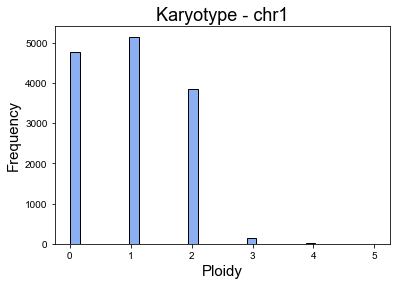

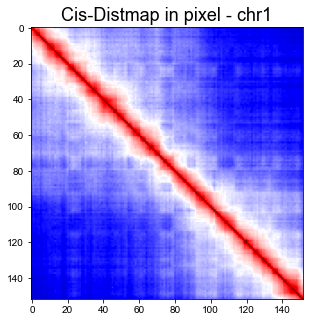

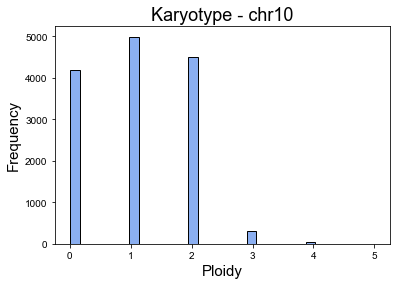

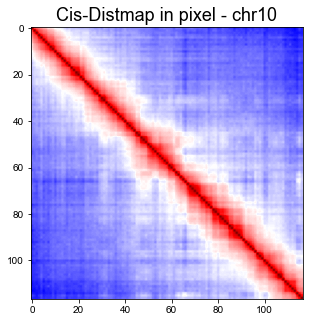

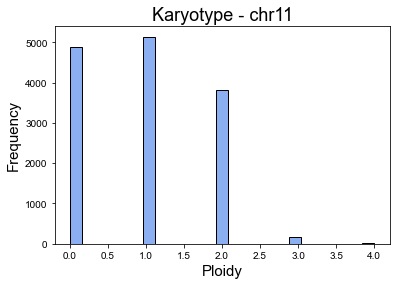

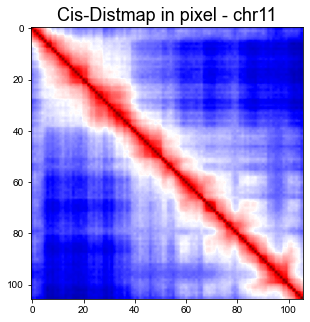

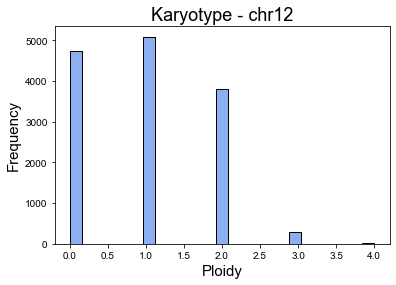

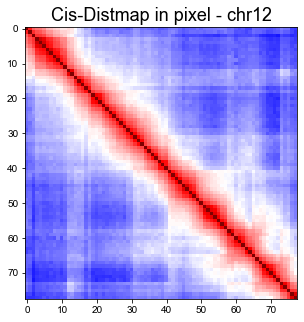

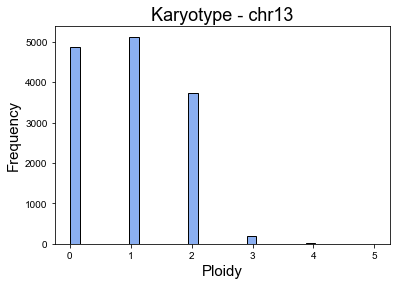

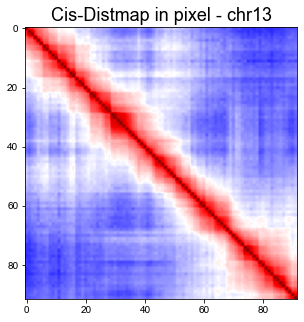

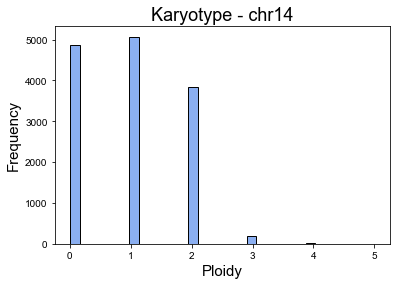

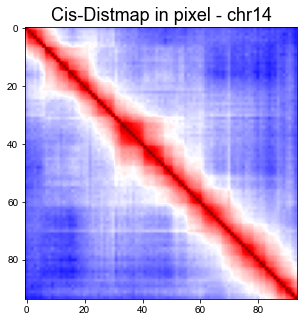

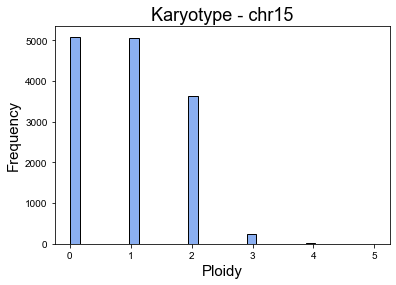

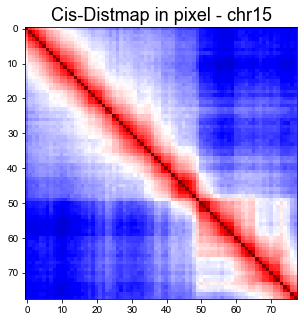

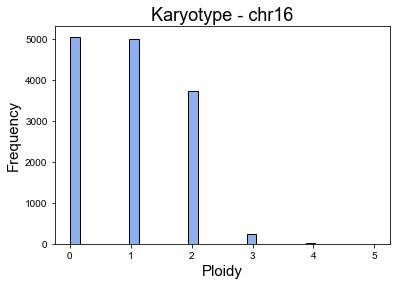

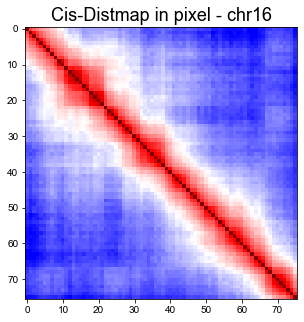

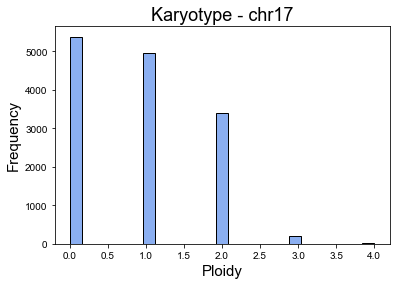

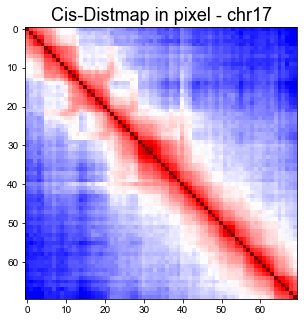

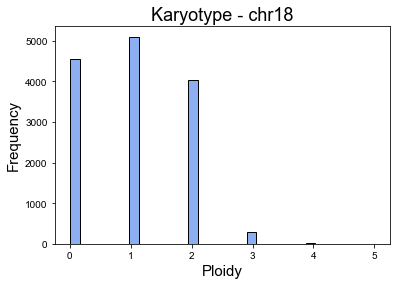

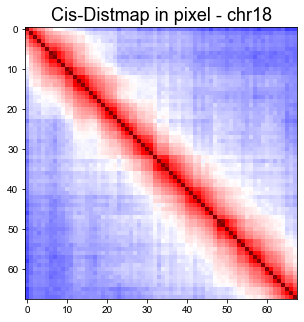

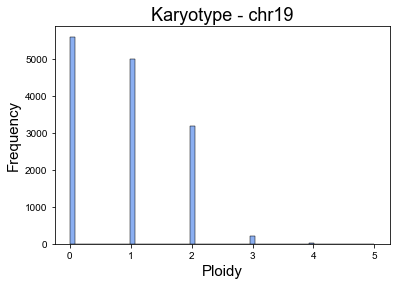

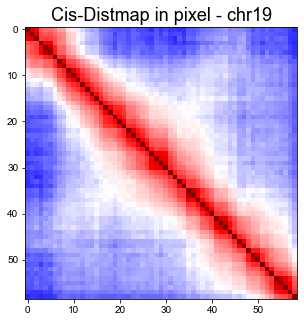

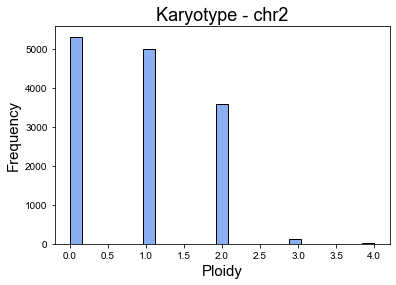

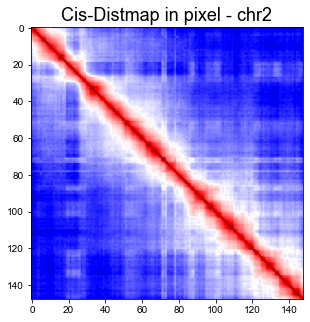

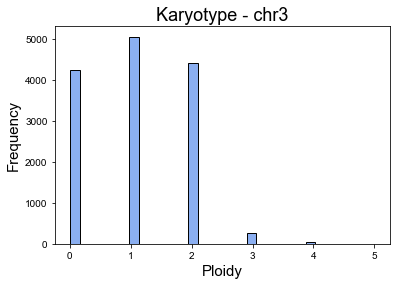

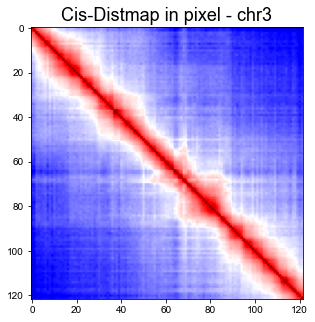

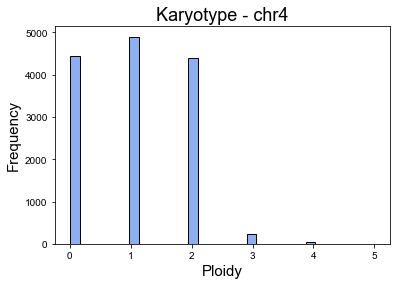

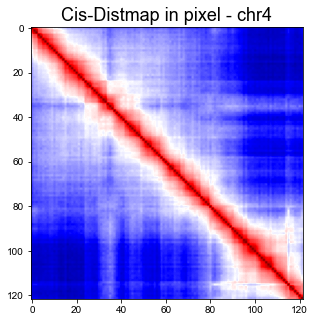

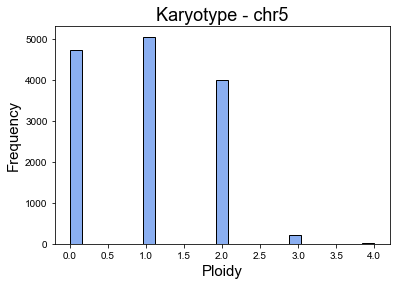

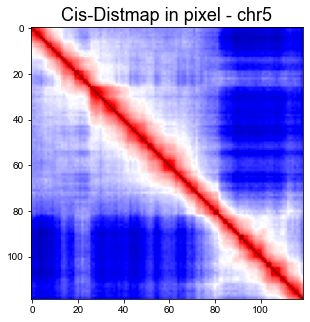

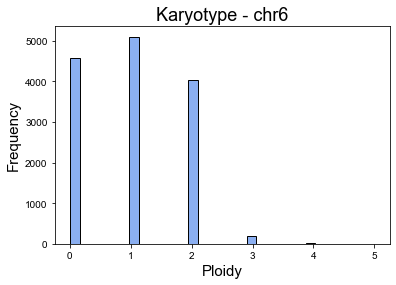

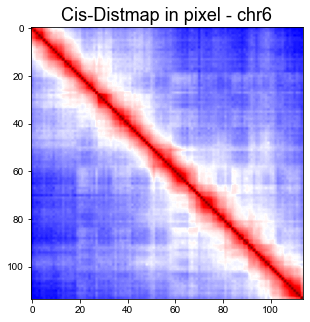

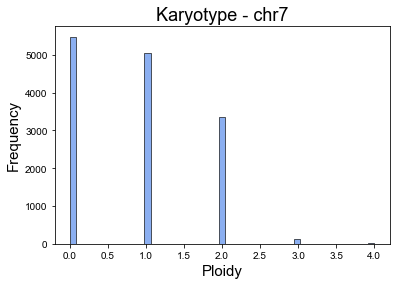

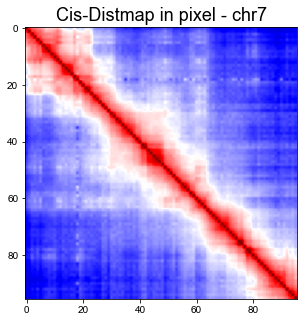

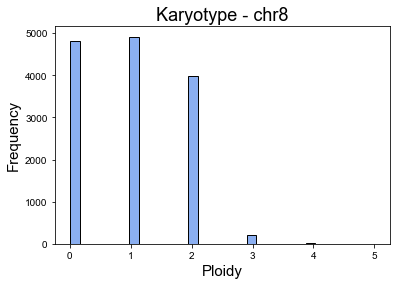

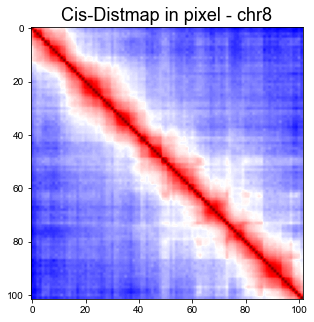

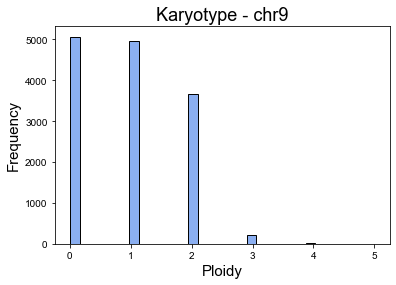

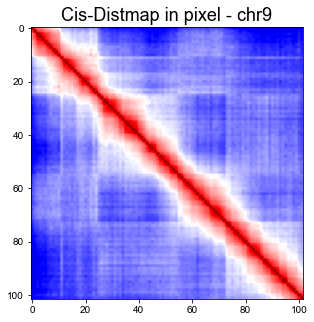

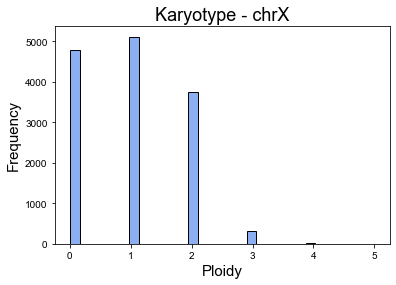

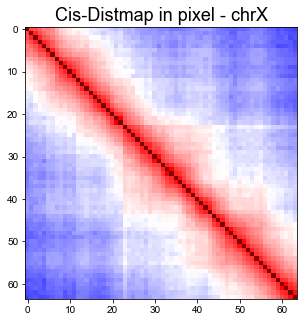

In [36]:
# pick spot with given params and plot result
%matplotlib inline

_save_pick = True


if __name__ == '__main__':
    
    #for chosen_chrom in params.keys():
    for chosen_chrom in sel_chrom_keys:
        
        if _save_pick:
            outputfile_name = f'{dna_exp_key}exp_pick_{chosen_chrom}'+'.h5'
            outputfile = os.path.join(merged_spot_folder, output_subfolder, outputfile_name)
            if not os.path.exists(os.path.join(merged_spot_folder, output_subfolder)):
                os.mkdir(os.path.join(merged_spot_folder, output_subfolder))
            if os.path.exists(outputfile):
                print('Picked file already exists.')
                continue
        
        
        print(f'Start processing chromosome {chosen_chrom}.')
        
        print(f'Loading shared parameters as: num_skip:{num_skip}, isf:{isf},tsf:{tsf},nm_per_bp:{nm_per_bp}.')
        ####################################################
        # pick spots for each chr-fiber with mp of each cell
        # grab candidate coordinates
        sel_chr_pts = chr_pts[(chr_pts['chr'] == chosen_chrom)]['data'].tolist()
        
        # additional clean up for chr1 and chr3 
        if chosen_chrom in ['chr1','chr3']:
            redun_hyb_pair = redun_hyb_dict[chosen_chrom]
            sel_chr_pts_clean=[]
            for _chr_pt in sel_chr_pts:
                sel_chr_pts_clean.append(process_redun_hyb_df (_chr_pt, redun_hyb_pair, hyb_col = 'hyb', drop_redun = False))
            sel_chr_pts=sel_chr_pts_clean

        # grab reference genome (and clean up ref_df if chr1 or chr3)
        df_refgen_chr = df_refgen[df_refgen['chr'] == chosen_chrom]
        if chosen_chrom in ['chr1','chr3']:
            df_refgen_chr = process_redun_hyb_df (df_refgen_chr, redun_hyb_pair, hyb_col = 'hyb', drop_redun = True)
            
        gene_dist = df_refgen_chr['delta']
        # estimate bin size
        loci_starts = df_refgen_chr['start']
        intervals = [j-i for i, j in zip(loci_starts[:-1], loci_starts[1:])]
        bin_size = np.median(intervals)
        
        # set params
        nm_per_bps = [nm_per_bp,] * len(sel_chr_pts)
        #cdfs_threshs = [cdfs_thresh, ] * len(sel_chr_pts)
        num_skips = [num_skip,] * len(sel_chr_pts) 
        bin_sizes = [bin_size,] * len(sel_chr_pts)
        total_num_skip_fracs = [tsf,] * len(sel_chr_pts)
        init_num_skip_fracs = [isf,] * len(sel_chr_pts)
        gene_dists = [gene_dist.values,] * len(sel_chr_pts)
        l_p_bps = [l_p_bp, ] * len(sel_chr_pts)

        start_time = time.time()
            
        with mp.Pool(12) as pick_pool:
            pick_res = pick_pool.starmap(aligner.find_all_chr, zip(sel_chr_pts, gene_dists, bin_sizes,
                                                                      nm_per_bps, num_skips, 
                                                                      total_num_skip_fracs,
                                                                      init_num_skip_fracs, l_p_bps), chunksize=1)
            pick_pool.close()
            pick_pool.join()
            pick_pool.terminate()
        
        elapsed_time = time.time() - start_time
        
        print(f'Finish processing chromosome {chosen_chrom}')
        hours, rem = divmod(elapsed_time, 3600)
        minutes, seconds = divmod(rem, 60)
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))
        ###################################################
        # report chrom ploidy number, which could used to adjust the nm_per_bp

        karyo_new = [len(elem) for elem in pick_res]
        karyo_new_arr = np.array(karyo_new)
        frac_dip = (np.sum(karyo_new_arr==2)+np.sum(karyo_new_arr==1))/len(karyo_new_arr)
        frac_tri = (np.sum(karyo_new_arr>2)/len(karyo_new_arr))
        print(f'{round(frac_dip*100,1)}% cells have one or two copie(s); and {round(frac_tri*100,1)}% have more than three copies')
        ##############################################
        
        # quick view of the pick info
        # plot ploidy number
        figure_folder = os.path.join(merged_spot_folder,output_subfolder,'figures')
        if not os.path.exists(figure_folder):
            os.mkdir(figure_folder)
        
        fig, axs = plt.subplots(figsize = (6, 4))
        sns.histplot(karyo_new, color='cornflowerblue');
        axs.set_ylabel('Frequency', fontsize = 15)
        axs.set_xlabel('Ploidy', fontsize = 15)
        axs.set_title('Karyotype - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_chr_ploidy_.png"))


        # plot distmap
        res_flat = [fiber for cell_res in pick_res for fiber in cell_res]
        med_dist_mat = plot.calc_med_dist_mat(res_flat, len(gene_dist))
        fig, axs = plt.subplots(figsize = (5, 5))
        axs.imshow(med_dist_mat*100, cmap = 'seismic_r', vmin=0, vmax = 3000)
        axs.set_title('Cis-Distmap in pixel - {0}'.format(chosen_chrom), fontsize = 18)
        fig.savefig(os.path.join(figure_folder, f"{dna_exp_key}exp_pick_{chosen_chrom}_distmap.png"))


        ###################################################
        # save individual df and concat
        if _save_pick:
            _res_flat_list = []
            # each cell
            for  _res in pick_res:
                # each fiber haploid
                if len(_res)>0:
                    for _fiber_ind, _fiber in enumerate(_res):
                        _fiber['fiberidx']=_fiber_ind+1
                        _res_flat_list.append(_fiber)
            merged_pick_res =  pd.concat(_res_flat_list)
            # clean up for chr1 or chr3
            if chosen_chrom in ['chr1','chr3']:
                merged_pick_res['hyb']=merged_pick_res['hyb_copy']
                merged_pick_res=merged_pick_res.drop(columns=['hyb_copy'])
                
            merged_pick_res.to_hdf(outputfile, key='df', mode='w')
            del(_res_flat_list)
            del(merged_pick_res)
            print(f'Finish saving chromosome {chosen_chrom}.')
            print(f'+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        